In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os

import utils

In [2]:
from sklearn.base import BaseEstimator

from sklearn.linear_model import Ridge, Lasso,RidgeCV, ElasticNet, LassoCV, LassoLarsCV

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler

from sklearn.feature_selection import SelectKBest
from sklearn import feature_selection
from sklearn import feature_selection

import lightgbm as lgb
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression

from catboost import Pool, CatBoostClassifier, cv, MetricVisualizer,CatBoostRegressor

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from scipy.stats import skew

In [4]:
from catboost import CatBoostRegressor

In [5]:
#update pandas up to 24 version

# Загрузка данных

In [89]:
#path_to_data = '../../../../_datasets/kaggle.House Prices/'
path_to_data = '../../_datasets/kaggle.House Prices/'

In [90]:
train_df = pd.read_csv(os.path.join(path_to_data, 'train.csv'), index_col = ['Id'])
test_df  = pd.read_csv(os.path.join(path_to_data, 'test.csv'), index_col = ['Id'])

train_df.shape, test_df.shape

((1460, 80), (1459, 79))

In [91]:
train_df = train_df[train_df.GrLivArea < 4000]
train_df.shape

(1456, 80)

# Feature engineering

In [92]:
num_features    = utils.num_features    # численные переменные
cat_features    = utils.cat_features    # категориальные переменные
count_features  = utils.count_features  # категориальные, упорядоченные (aka кол-во мест в гараже)
date_features   = utils.date_features   # даты, периоды

cat_features = cat_features + count_features

In [93]:
# Log transform the target for official scoring
train_df.SalePrice = np.log1p(train_df.SalePrice)
y = train_df.SalePrice

In [94]:
# Объединение датасетов для удобства обработки
full_df = pd.concat([train_df.drop('SalePrice', axis=1), test_df])
idx_split = train_df.shape[0]

full_df.shape, train_df.shape

((2915, 79), (1456, 80))

In [95]:
# Возраст дома на момент продажи
full_df['Age']       = full_df['YrSold'] - full_df['YearBuilt']

# Срок ремонта дома на момент продажи
full_df['AgeRemod']  = full_df['YrSold'] - full_df['YearRemodAdd']

# Возраст гаража на момент продажи
full_df['GarageAge'] = full_df['YrSold'] - full_df['GarageYrBlt']


# Добавление новых фич в набор
num_features = num_features + ['Age', 'AgeRemod', 'GarageAge']
# Удаление лишних фич
full_df = full_df.drop(['YearBuilt', 'GarageYrBlt', 'YearRemodAdd'], axis = 1)


In [96]:
# mean_target encoder для фич YrSold и MoSold

mean_target_YrSold = train_df.groupby(['YrSold']).SalePrice.mean()
mean_target_MoSold = train_df.groupby(['MoSold']).SalePrice.mean()

full_df['mean_target_YrSold'] = full_df.YrSold.map(mean_target_YrSold)
full_df['mean_target_MoSold'] = full_df.MoSold.map(mean_target_MoSold)

# Добавление новых фич в набор
num_features = num_features + ['mean_target_YrSold', 'mean_target_MoSold']

# Удаление лишних фич
#full_df = full_df.drop(['MoSold', 'YrSold'], axis = 1)

In [97]:
# Заполнение null для basement

full_df['is_bsmt'] = full_df.TotalBsmtSF.map(lambda x: 1 if x>0 else 0)
cat_features = cat_features + ['is_bsmt']


bsmt_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1',
             'BsmtFinType2', 'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']

bsmt_cat_cols = list(set(cat_features).intersection(set(bsmt_cols)))
bsmt_num_cols = list(set(num_features).intersection(set(bsmt_cols)))


full_df.loc[:, bsmt_num_cols] = full_df.loc[:, bsmt_num_cols].fillna(0)
full_df.loc[:, bsmt_cat_cols] = full_df.loc[:, bsmt_cat_cols].fillna('no_basement')

In [98]:
# Заполнение null для garage

# доп.фича наличие гаража
full_df['is_garage'] = full_df.GarageArea.map(lambda x: 1 if x>0 else 0)
cat_features = cat_features + ['is_garage']


garage_cols = ['GarageType','GarageFinish','GarageCars','GarageArea',
               'GarageQual','GarageCond', 'GarageAge', 'is_garage']

garage_cat_cols = list(set(cat_features).intersection(set(garage_cols)))
garage_num_cols = list(set(num_features).intersection(set(garage_cols)))


full_df.loc[:, garage_num_cols] = full_df.loc[:, garage_num_cols].fillna(0)
full_df.loc[:, garage_cat_cols] = full_df.loc[:, garage_cat_cols].fillna('no_garage')


In [99]:
# Заполнение null для остальных

full_df.loc[:, 'MSZoning'] = full_df.loc[:, 'MSZoning'].fillna("not_available")
full_df.loc[:, "Functional"] = full_df.loc[:, "Functional"].fillna("Typ")
full_df.loc[:, "KitchenQual"] = full_df.loc[:, "KitchenQual"].fillna("TA")
full_df.loc[:, "MasVnrType"] = full_df.loc[:, "MasVnrType"].fillna("None")
full_df.loc[:, "Exterior2nd"] = full_df.loc[:, "Exterior2nd"].fillna("not_available")
full_df.loc[:, "FireplaceQu"] = full_df.loc[:, "FireplaceQu"].fillna("No")
full_df.loc[:, "SaleType"] = full_df.loc[:, "SaleType"].fillna("Other")
full_df.loc[:, "Alley"] = full_df.loc[:, "Alley"].fillna("None")
full_df.loc[:, "Utilities"] = full_df.loc[:, "Utilities"].fillna("AllPub")
full_df.loc[:, "MiscFeature"] = full_df.loc[:, "MiscFeature"].fillna("No")
full_df.loc[:, "Fence"] = full_df.loc[:, "Fence"].fillna("No")
full_df.loc[:, "Electrical"] = full_df.loc[:, "Electrical"].fillna('Mixed')
full_df.loc[:, "PoolQC"] = full_df.loc[:, "PoolQC"].fillna("No")
full_df.loc[:, "Exterior1st"] = full_df.loc[:, "Exterior1st"].fillna("not_available")

full_df.loc[:, "LotFrontage"] = full_df.loc[:, "LotFrontage"].fillna(0)
full_df.loc[:, "MasVnrArea"] = full_df.loc[:, "MasVnrArea"].fillna(0)
full_df.loc[:, "BsmtFullBath"] = full_df.loc[:, "BsmtFullBath"].fillna(0)
full_df.loc[:, "BsmtHalfBath"] = full_df.loc[:, "BsmtHalfBath"].fillna(0)


In [100]:
# Проверка наличия пустых значений
na_cols = full_df.isnull().any()
na_cols[na_cols == True]

Series([], dtype: bool)

In [101]:
# Проверка и исправление типов object
full_df[cat_features] = full_df[cat_features].astype('object')

In [102]:
#log transform skewed numeric features:
numeric_feats = full_df.dtypes[full_df.dtypes != "object"].index

skewed_feats = full_df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
full_df[skewed_feats] = np.log1p(full_df[skewed_feats])

In [103]:
# Проверка

others = ['MSZoning','LotFrontage','Alley','Utilities','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea',
'Electrical','BsmtFullBath','BsmtHalfBath','KitchenQual','Functional','FireplaceQu','PoolQC','Fence',
'MiscFeature','SaleType']

g_cat_cols = list(set(cat_features).intersection(set(others)))
g_num_cols = list(set(num_features).intersection(set(others)))

In [104]:
X_train = full_df.iloc[:idx_split,:]
X_test  = full_df.iloc[idx_split:,:]

y_train = train_df.SalePrice

# Visual

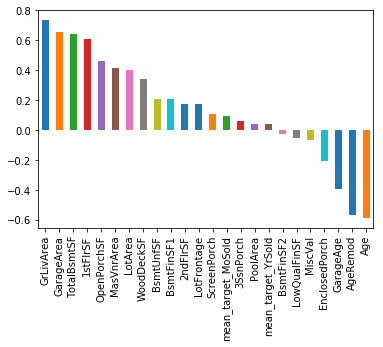

In [105]:
X_train[num_features].corrwith(y_train).sort_values(ascending = False).plot(kind = 'bar')

In [106]:
X_train.GrLivArea.shape, y_train.shape

((1456,), (1456,))

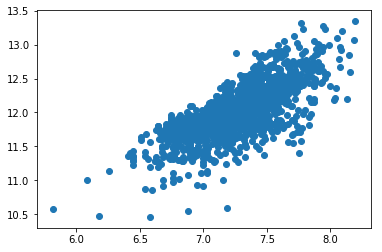

In [107]:
plt.scatter(X_train.GrLivArea, y_train)

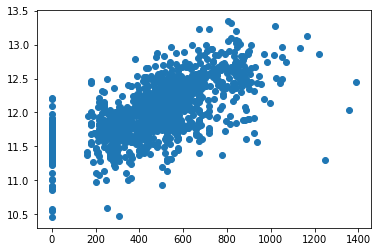

In [108]:
plt.scatter(X_train.GarageArea, y_train)

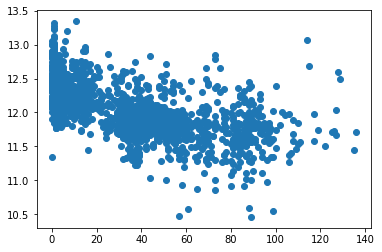

In [109]:
plt.scatter(X_train.Age, y_train)

In [110]:
#X_train[cat_features].corrwith(y_train, 'spearman').sort_values(ascending = False).plot(kind = 'bar')

# Cross_validation

In [111]:
class ItemSelector(BaseEstimator):
    def __init__(self, colname):
        self.colname = colname
        pass
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return x[self.colname].values

In [112]:
# Числовые признаки
num_pipe = Pipeline([
    ('num_features', ItemSelector(num_features)),
    ('scaler', StandardScaler()),
])

# Категориальные признаки
cat_pipe = Pipeline([
    ('cat_features', ItemSelector(cat_features)),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore', sparse = False)),
])

In [113]:
cv_splits = KFold(n_splits=5, shuffle=True, random_state=17)

### LassoCV

In [114]:
class LassoCV_custom(LassoCV):
    def transform(self, x):
        return super(LassoCV_custom, self).predict(x).reshape(-1, 1)
    
model_lasso = LassoCV_custom()

In [126]:
lasso_pipe = Pipeline([
    ('feature_union', FeatureUnion([
        ('num_pipe', num_pipe),
        ('cat_pipe', cat_pipe)
    ])),
    #('select', SelectKBest(score_func=feature_selection.f_regression, k = 300)),
    ('model_lasso', LassoCV_custom(alphas = [1, 0.1, 0.00001, 0.0005]))
    #('model_lasso', LinearRegression())
  
])

In [127]:
scores = cross_val_score(lasso_pipe,  X_train, y_train,
                         cv = cv_splits, scoring = 'neg_mean_squared_error'
                        )

print(lasso_pipe, (-scores.mean())**0.5, scores.std())

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('num_features', ItemSelector(colname=['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',...alse, precompute='auto',
        random_state=None, selection='cyclic', tol=0.0001, verbose=False))]) 0.11301232252803317 0.0011530132881969425


In [128]:
lasso_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('num_features', ItemSelector(colname=['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',...alse, precompute='auto',
        random_state=None, selection='cyclic', tol=0.0001, verbose=False))])

In [129]:
#lasso_pipe.named_steps['model_lasso'].coef_

### XGBoost

In [130]:
class XGB_custom(xgb.XGBRegressor):
    def transform(self, x):
        return super(XGB_custom, self).predict(x).reshape(-1, 1)
    
model_xgb = XGB_custom()

In [131]:
xgb_pipe = Pipeline([
    ('feature_union', FeatureUnion([
        ('num_pipe', num_pipe),
        ('cat_pipe', cat_pipe)
    ])),
    ('select', SelectKBest(score_func=feature_selection.f_regression, k = 300)),
    ('model_lgb', model_xgb)
])

In [132]:
scores = cross_val_score(xgb_pipe,  X_train, y_train,
                         cv = cv_splits, scoring = 'neg_mean_squared_error'
                        )

print(xgb_pipe, (-scores.mean())**0.5, scores.std())

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('num_features', ItemSelector(colname=['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',...0,
      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
      silent=True, subsample=1))]) 0.13018720207850415 0.0011656870779390908


### LightGBM

In [133]:
class LGBM_custom(lgb.LGBMRegressor):
    def transform(self, x):
        return super(LGBM_custom, self).predict(x).reshape(-1, 1)
    
model_lgb = LGBM_custom()

In [136]:
lgb_pipe = Pipeline([
    ('feature_union', FeatureUnion([
        ('num_pipe', num_pipe),
        ('cat_pipe', cat_pipe)
    ])),
    ('select', SelectKBest(score_func=feature_selection.f_regression, k = 300)),
    ('model_lgb', model_lgb)
])

In [137]:
scores = cross_val_score(lgb_pipe,  X_train, y_train,
                         cv = cv_splits, scoring = 'neg_mean_squared_error'
                        )

print(lgb_pipe, (-scores.mean())**0.5, scores.std())

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('num_features', ItemSelector(colname=['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',...0.0, reg_lambda=0.0, silent=True,
      subsample=1.0, subsample_for_bin=200000, subsample_freq=0))]) 0.13185529915500516 0.0021971781279490517


### CatBoost

In [138]:
class CB_custom(CatBoostRegressor):
    def transform(self, x):
        return super(CB_custom, self).predict(x).reshape(-1, 1)    
    
model_cb = CB_custom(logging_level='Silent')

In [139]:

cb_pipe = Pipeline([
    ('feature_union', FeatureUnion([
        ('cat_features', ItemSelector(cat_features)),
        ('num_pipe', num_pipe)
    ])),
    
    ('model_cb', CB_custom())
])


In [140]:

cat_features_index = list(range(len(cat_features)))

fit_params = {
    'model_cb__cat_features': cat_features_index,
    'model_cb__logging_level':'Silent'
}

scores = cross_val_score(cb_pipe,  X_train, y_train,
                         cv = cv_splits, scoring = 'neg_mean_squared_error',
                         fit_params = fit_params
                    )

print(cb_pipe, (-scores.mean())**0.5, scores.std())


Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('cat_features', ItemSelector(colname=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'Ove...))],
       transformer_weights=None)), ('model_cb', <__main__.CB_custom object at 0x7ff49a402438>)]) 0.1909672296188825 0.004542318712503654


### Метамодель на основе catboost

с включением в качестве фич результатов предсказания предыдущих моделей

In [141]:
cb_stacking_pipe = Pipeline([
    
    ('feature_union', FeatureUnion([
        ('cat_features', ItemSelector(cat_features)),
        ('num_pipe', num_pipe),
        
        ('lasso_pipe', lasso_pipe),
        ('lgb_pipe',   lgb_pipe),
        ('xgb_pipe',   xgb_pipe),
        
    ])),  
    ('model_cb', CatBoostRegressor())
])

In [137]:

cat_features_index = list(range(len(cat_features)))

fit_params = {
    'model_cb__cat_features': cat_features_index,
    'model_cb__logging_level':'Silent'
}

scores = cross_val_score(cb_stacking_pipe,  X_train, y_train,
                         cv = cv_splits, scoring = 'neg_mean_squared_error',
                         fit_params = fit_params
                    )

print(cb_stacking_pipe, (-scores.mean())**0.5, scores.std())

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('lasso_pipe', Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('num_features', ItemSelector(colname=['WoodDeckSF', 'OpenP...ransformer_weights=None)), ('model_cb', <catboost.core.CatBoostRegressor object at 0x7fac5443f9b0>)]) 0.21647773887609836 0.016679513450021305


### Метамодель на основе lasso

In [145]:
lasso_stacking_pipe = Pipeline([
    
    ('feature_union', FeatureUnion([
        ('num_pipe', num_pipe),
        ('cat_pipe', cat_pipe),
        
        #('lgb_pipe',   lgb_pipe),
        ('xgb_pipe',   xgb_pipe),
        
    ])),  
    ('model_lasso', LassoCV_custom(alphas = [1, 0.1, 0.00001, 0.0005]))
])

In [66]:
scores = cross_val_score(lasso_stacking_pipe,  X_train, y_train,
                         cv = cv_splits, scoring = 'neg_mean_squared_error'
                        )

print(lasso_pipe, (-scores.mean())**0.5, scores.std())

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('num_features', ItemSelector(colname=['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',...alse, precompute='auto',
        random_state=None, selection='cyclic', tol=0.0001, verbose=False))]) 0.12721991873431418 0.0011990675684673009


### Усреднение результатов нескольких моделей

In [146]:
b_pipe = Pipeline([
    ('feature_union', FeatureUnion([
        #('xgb_pipe',   xgb_pipe),
        #('lgb_pipe',   lgb_pipe),
        ('lasso_pipe', lasso_pipe),
        #('cb_pipe',    cb_pipe),
    ]))
])

In [147]:
b_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('lasso_pipe', Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('num_pipe', Pipeline(memory=None,
     steps=[('num_features', ItemSelector(colname=['WoodDeckSF', 'OpenP..._state=None, selection='cyclic', tol=0.0001, verbose=False))]))],
       transformer_weights=None))])

In [148]:
x = lasso_stacking_pipe.transform(X_test)
x

NotFittedError: This SelectKBest instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [79]:

y_test_pred = np.expm1(np.mean(x, axis = 1)) #0.13355,

In [80]:
y_test_pred

array([124018.25696327, 150640.09172384, 194873.43624021, ...,
       146974.82440912, 125567.36506747, 216771.20269891])

# Сохранение данных

In [150]:
sample_submission = pd.read_csv(os.path.join(path_to_data, 'sample_submission.csv'), index_col = ['Id'])
sample_submission['SalePrice'] = y_test_pred.values

sample_submission.to_csv('result6.csv') #0.0.13192

# Mixin

In [88]:
f = pd.read_csv('result5.csv')
f.head()

,Id,SalePrice
0,1461,121631.759683
1,1462,152127.779840
2,1463,188107.567976
3,1464,194034.152933
4,1465,188947.475859


In [149]:
y_test_pred = 0.4*f.SalePrice + 0.6*y_test_pred

In [ ]:
##################################################################################

In [8]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [9]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [24]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [25]:
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [26]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 117
Categorical features : 26


In [292]:
X_pipe = Pipeline([
    ('feature_union', FeatureUnion([
        ('cat_features', ItemSelector(cat_features))
    ]))
])
    
X_pipe.transform(X_train)

array([[4.110873864173311, 'RL', 'Pave', ..., 'Normal', 1, 1],
       [3.044522437723423, 'RL', 'Pave', ..., 'Normal', 1, 1],
       [4.110873864173311, 'RL', 'Pave', ..., 'Normal', 1, 1],
       ...,
       [4.2626798770413155, 'RL', 'Pave', ..., 'Normal', 1, 1],
       [3.044522437723423, 'RL', 'Pave', ..., 'Normal', 1, 1],
       [3.044522437723423, 'RL', 'Pave', ..., 'Normal', 1, 1]],
      dtype=object)

In [239]:
lasso_pipe = Pipeline([
    ('feature_union', FeatureUnion([
        #('num_pipe', num_pipe),
        ('cat_pipe', cat_pipe)
    ]))
])

In [240]:
lasso_pipe.transform(X_train).shape

(1460, 365)